In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '.'

IRLS Algorithm
--------------
Define the problem parameters


In [3]:
A = np.array([[1, 3], [3, 1]]) # low dimensions to plot it, you can test larger sizes
b = np.array([-1, 2])

lmbda = 0.5


The function to be minimized is $\frac{1}{2}\|Ax-b\|_2^2 + \lambda \|x\|_1$

In [4]:
f = lambda x: 0.5 * np.sum((A @ x - b) ** 2) + lmbda * np.sum(np.abs(x))

# derivative of f from matrix calculus
df = lambda x: A.T @ (A @ x) - A.T @ b


Plot the function

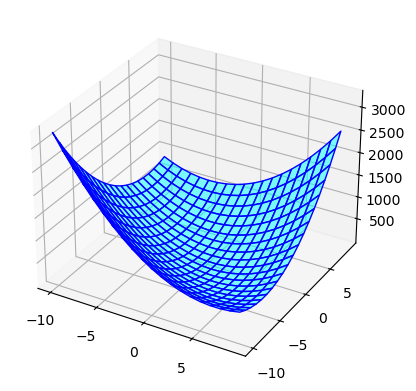

In [5]:
# this function has been prepared only for the visualization sake, no need to go through this but it renders some nice
# graphics :)
F = lambda r1, r2: (r1 * A[0, 0] + r2 * A[0, 1] - b[0]) ** 2 + (r1 * A[1, 0] + r2 * A[1,1] - b[1]) ** 2 + lmbda * (np.abs(r1) + np.abs(r2))
xx, yy = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, F(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])

Set the parameters

In [36]:
MAX_ITER = 1e3
TOL_DIST_X = 1e-10

Initialization: test different inizializations, the function is convex, you always converge to the same solution

In [37]:
x0 = np.array([5, -10])

# initialization
all_x = [x0]
distanceX = 1e10  # stopping criteria
cnt = 0
delta = 1e-6

Main loop

In [38]:
while cnt < MAX_ITER and distanceX > TOL_DIST_X:
    x = all_x[-1]

    # compute the weight matrix
    W = np.diag(1 / (np.abs(x) + delta))

    # solve the weighted regularized LS system
    x_current = np.linalg.inv(A.T @ W @ A + lmbda * np.eye(2)) @ (A.T @ W @ b)

    distanceX = np.linalg.norm(x_current - x)

    # store the estimate
    # update all_x
    all_x.append(x_current)

    cnt = cnt + 1

Plot all the estimates

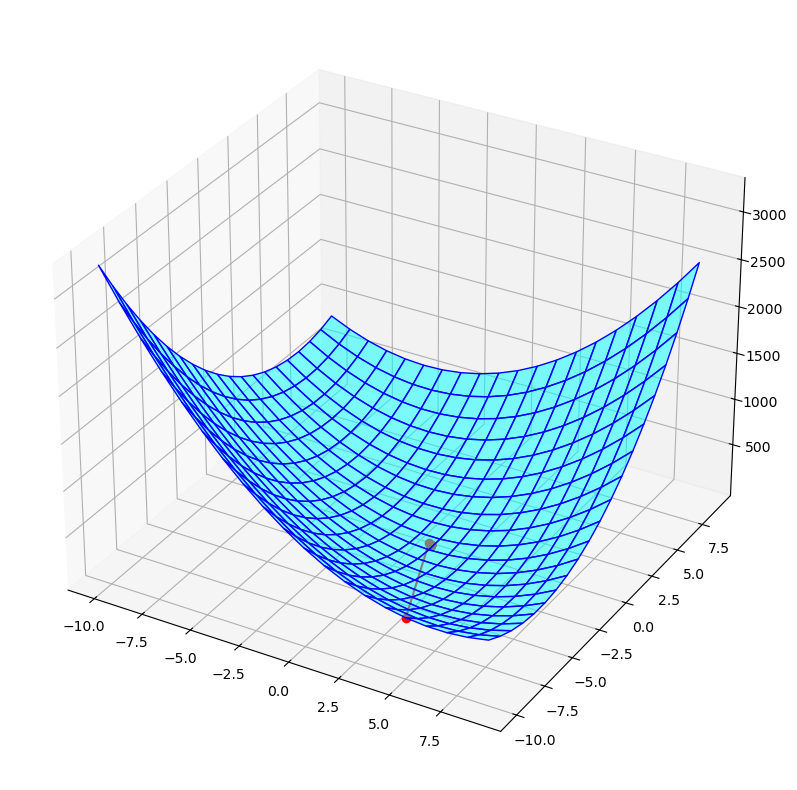

In [39]:
# plot the new estimate
xxplot = [x[0] for x in all_x]
yyplot = [x[1] for x in all_x]
zzplot = F(np.array(xxplot), np.array(yyplot))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, F(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])
ax.plot3D(xxplot, yyplot, zzplot, 'r-o')

In [40]:
print(f'nr of iteration of IRLS (before stopping criteria met): {cnt}\n')
print(f'Solution of IRLS: [{x_current[0]:.4f}, {x_current[1]:.4f}]\n')
print(f'Value of the functional: {f(x_current):.4f}\n')


nr of iteration of IRLS (before stopping criteria met): 8

Solution of IRLS: [0.8622, -0.6111]

Value of the functional: 0.1480



MOD dictionary learning
-----------------------
Useful function for plot the 2D DCT dictionary

In [27]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function to perform the sparse coding using your favorite algorithm (IRLS, FISTA or ISTA)

In [28]:
def IRLS(s, D, lmbda, x0=None):
    if x0 is None:
        x0 = np.zeros(D.shape[1])
    delta = 1e-6
    max_iter = 20
    distanceX = 1e10
    toll_x = 1e-3

    x = x0

    cnt = 0
    while cnt < max_iter or distanceX > toll_x:
        W = np.diag(1 / (np.abs(x) + delta))
        # solve the weighted regularized LS system
        x_new = np.linalg.solve((2 * lmbda * W + D.T @ D), D.T @ s)
        distanceX = np.linalg.norm(x - x_new, ord=2)
        x = x_new
        cnt = cnt + 1
    return x_new

Load the image and rescale it in [0,1]

In [29]:
img = imread('data/barbara.png') / 255
imsz = img.shape


Set the parameters

In [30]:
# patch size
p = 8

# number of elements in the patchfrom skimage.io import imread
M = p ** 2

# number of columns in the dictionary
N = 96

# extract the random patches from the noisy image
npatch = 1000

# only few MOD iterations are needed for a good dictionary
max_iter = 10

lmbda = 0.1

Extract $npatch$ random patches from the image


In [41]:
S = np.zeros((M, npatch))
for i in range(npatch):
    x = np.random.randint(0, imsz[0] - p)
    y = np.random.randint(0, imsz[1] - p)
    S[:, i] = img[x: x + p, y: y + p].flatten()

Initialize the dictionary randomly and the normalize the columns

In [42]:
D = np.random.randn(M, N)
for i in range(N):
    D[:, i] = D[:, i] / np.linalg.norm(D[:, i])


Initialize a matrix for the coefficients of all the patches

In [43]:
X = np.zeros((N, npatch))

Main loop

In [45]:
for iter in range(max_iter):

    # perform the sparse coding for all the patches in S
    for n in range(npatch):
        s = S[:, n]
        x = IRLS(s, D, lmbda)
        X[:, n] = x

    # MOD update through LS
    D = S @ X.T @ np.linalg.inv(X @ X.T)

    # normalize the column
    D = D / np.linalg.norm(D, axis=0)

    print(f'Iteration {iter + 1} completed\n')


Iteration 1 completed

Iteration 2 completed

Iteration 3 completed

Iteration 4 completed

Iteration 5 completed

Iteration 6 completed

Iteration 7 completed

Iteration 8 completed

Iteration 9 completed

Iteration 10 completed



Show the dictionary

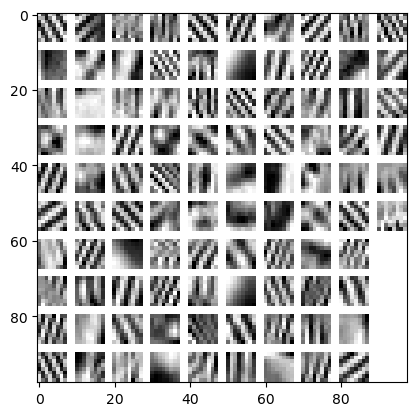

In [46]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')


Denoising via $\ell^1$ sparse coding
------------------------------------
Set the noise level and add the noise to the original image

In [65]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise


Compue the psnr of the noisy input

In [66]:
psnr_noisy = 10 * np.log10(1 / np.mean((img - noisy_img) ** 2))


Text(0.5, 1.0, 'Noisy image, PSNR = 22.10')

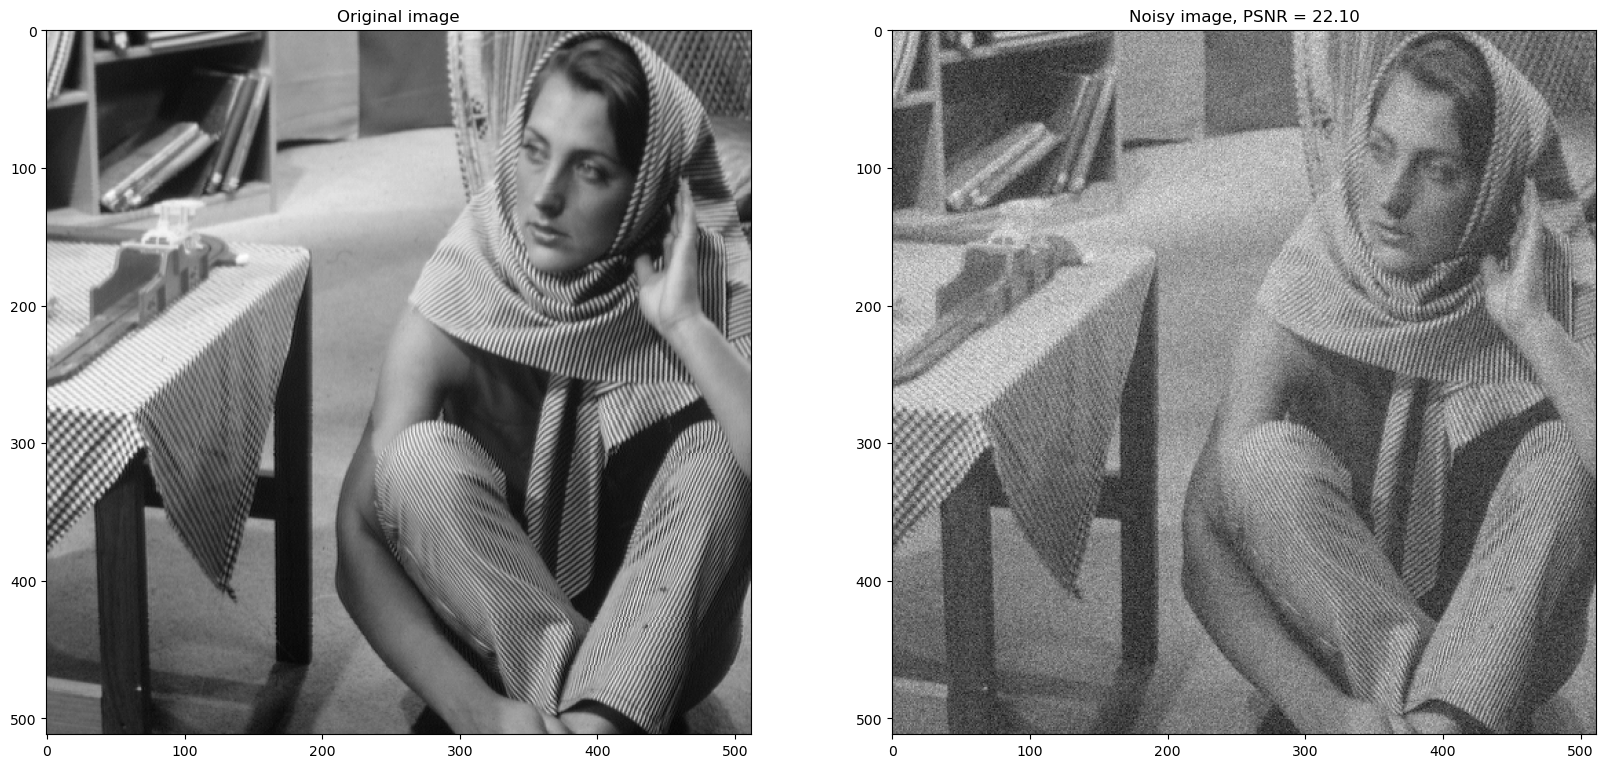

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

Use the dictionary computed with the MOD or load a pretrained dictionary $D$

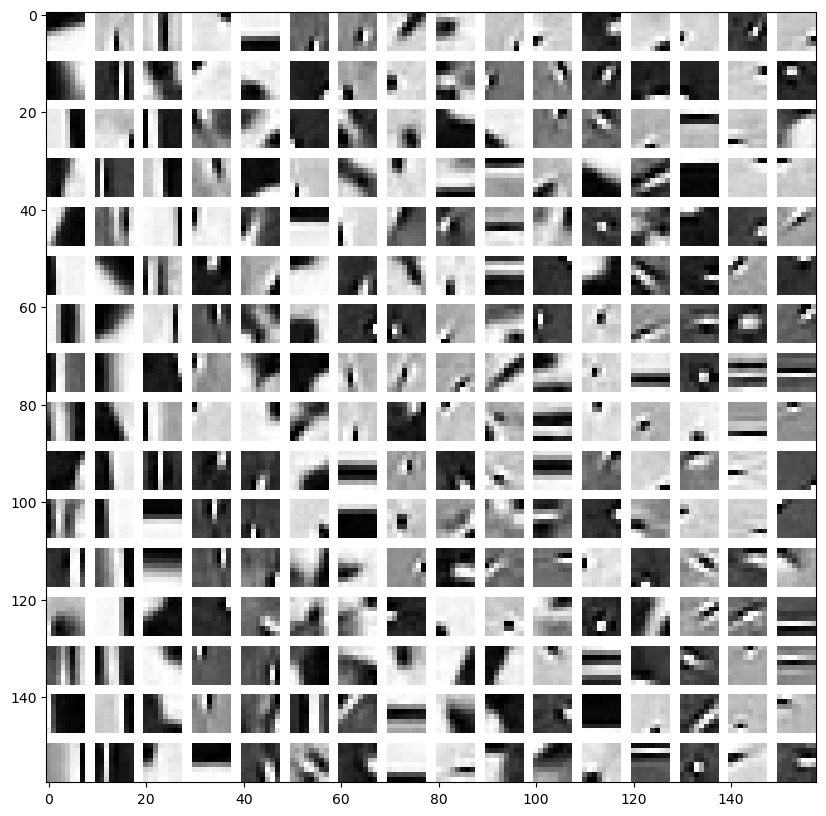

In [76]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# show the dictionary
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')


In [77]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold
tau = 2.2
lmbda = tau * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

In [78]:
def OMP(s, D, L, min_res_norm=0.1, verbose=True):
    """
    Orthogonal Matching Pursuit (OMP) algorithm for sparse signal recovery.

    Parameters:
    - s: numpy array, the input signal to be recovered
    - D: numpy array, the redundant dictionary matrix
    - L: int, the desired sparsity level
    - min_res_norm: float, optional, the minimum residual norm to stop the algorithm (default is 0.1)
    - verbose: bool, optional, whether to print information logging during the algorithm (default is True)

    Returns:
    - x_OMP: numpy array, the recovered sparse coefficients
    """

    # Initialization
    x_OMP = np.zeros(D.shape[1])    # coefficients
    r = s                           # residual vector
    omega = np.empty(0, dtype=int)  # support set
    res_norm = np.linalg.norm(r)    # norm of the residual vector

    # Main loop
    while np.count_nonzero(x_OMP) < L and res_norm > min_res_norm:
        # Sweep step
        e = np.zeros(D.shape[1])
        for j in range(D.shape[1]):
            e[j] = (res_norm ** 2) - (r.T @ D[:, j]) ** 2

        # Find the column of D that best matches the residual vector
        j_star = np.argmin(e)

        # Update the support set with the j_star coefficient
        omega = np.append(omega, j_star)

        # Update the coefficients by solving the least square problem argmin(||s - D_omega @ x_omega||)
        x_OMP = np.zeros(D.shape[1])
        x_OMP[omega] = np.linalg.inv(D[:, omega].T @ D[:, omega]) @ D[:, omega].T @ s

        # Update the residual
        r = s - D[:, omega] @ x_OMP[omega]

        # Update the residual norm
        res_norm = np.linalg.norm(r)

        # Information logging
        if verbose:
            print(f'Round {np.count_nonzero(x_OMP) + 1}: j_star = {j_star} with e[j_star] = {e[j_star]}')

    return x_OMP

Operate patchwise

In [79]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img[i: i + p, j: j + p].flatten()

        # store and subtract the mean
        mean = np.mean(s)

        s -= mean

        # perform the sparse coding of the patch s to compute the coefficients vector x
        x = OMP(s, D, 4, verbose=False)

        # perform the reconstruction
        s_hat = D @ x

        w = 1

        # add back the mean
        s_hat += mean

        # put the denoised patch into the estimated image using uniform weights
        # update img_hat
        img_hat[i: i + p, j: j + p] += s_hat.reshape((p, p))

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i: i + p, j: j + p] += 1

Normalize the estimated image with the computed weights

In [80]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.47')

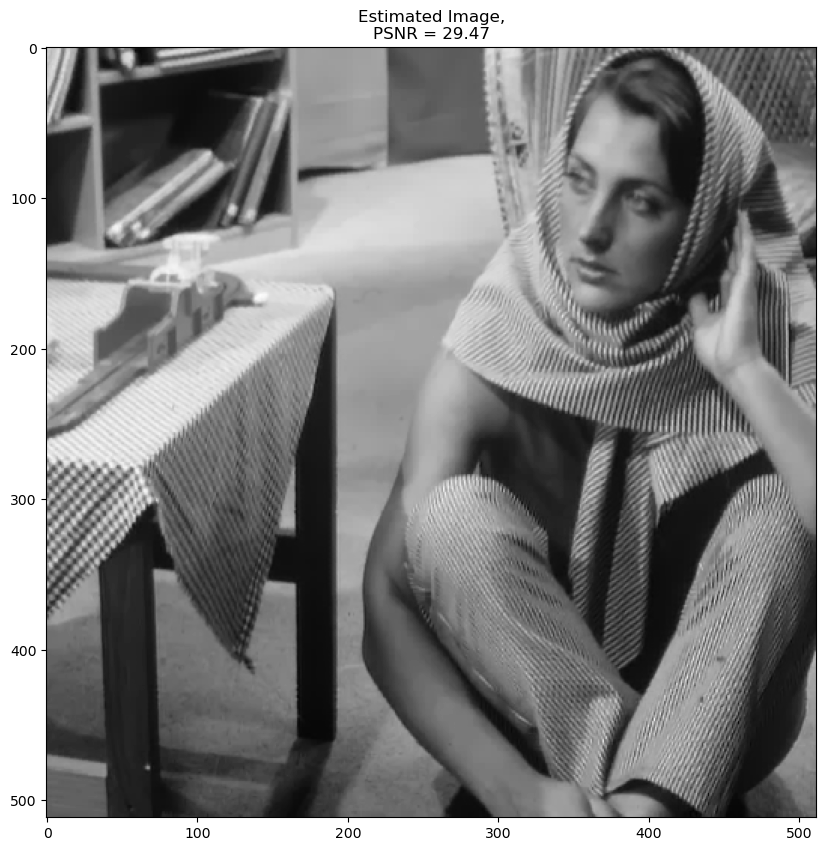

In [81]:
psnr_hat = 10*np.log10(1 / np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
